<a href="https://colab.research.google.com/github/willbastosferreira/projetos_ds/blob/main/Cc_Fraude_NuBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.


<center><img width="5%" src="https://miro.medium.com/max/1400/1*2FEwHebiKtnt4apFZz0wjw.png" =100x200></center>













Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*.

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$

<p align=center>
<img src="https://miro.medium.com/max/875/1*6sivl0aoOJ9yM5YMI34U2Q.png" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [15]:
# importando as bibliotecas

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn

sns.set_style('whitegrid')

In [16]:
# carregando arquivo


#os.chdir('C:\\Users\\basfe\\Documents\\Python Scripts\\Learning Data Science  - Will\\Data')
dados = pd.read_csv('creditcard.csv')

dados.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## Análise Exploratória

Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas permitem entender como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

* A variável alvo está representada na coluna `Class`, onde:
* **0:** Transação normal; e
* **1:** Transação fraudulenta;

Verificando abaixo o resumo estatístico, por meio do método `describe()`, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.


In [17]:
# resumo estatístico

dados.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,210013.000000,...,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000,210012.000000
mean,73737.509878,-0.085703,-0.002471,0.265572,0.063072,-0.091151,0.040804,-0.040030,0.011901,0.007007,...,-0.011627,-0.037288,-0.013747,0.003126,0.051676,0.004613,0.001043,0.001568,89.951723,0.001876
std,36513.266525,1.907570,1.629480,1.465058,1.403075,1.363654,1.314757,1.218114,1.203974,1.130707,...,0.735653,0.697612,0.617554,0.604496,0.498516,0.487684,0.395146,0.318274,248.087723,0.043273
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,45489.000000,-0.955127,-0.587401,-0.428764,-0.805003,-0.769694,-0.718087,-0.572324,-0.186724,-0.661958,...,-0.226297,-0.535085,-0.168195,-0.344903,-0.253835,-0.331420,-0.068170,-0.044455,5.990000,0.000000
50%,69325.000000,-0.062899,0.076713,0.445943,0.063919,-0.150262,-0.225473,-0.001614,0.039117,-0.071405,...,-0.039727,-0.025132,-0.026832,0.050656,0.092614,-0.061362,0.004968,0.017487,23.000000,0.000000
75%,110010.000000,1.225287,0.781543,1.194398,0.866750,0.492869,0.440468,0.515107,0.335470,0.621224,...,0.157789,0.443546,0.119421,0.424135,0.380435,0.258253,0.089003,0.077898,79.580000,0.000000
max,137803.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou que demandasse uma etapa de limpeza. Na função abaixo, perceba que o maior valor por coluna para valores nulos é zero, o que confirma que não há valores ausentes.

In [18]:
# verificando dados missing values (dados ausentes)

dados.isnull().sum().max()

1

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

0.0    209618
1.0       394
Name: Class, dtype: int64

Fraudes representam 0.1876% do dataset.



[]

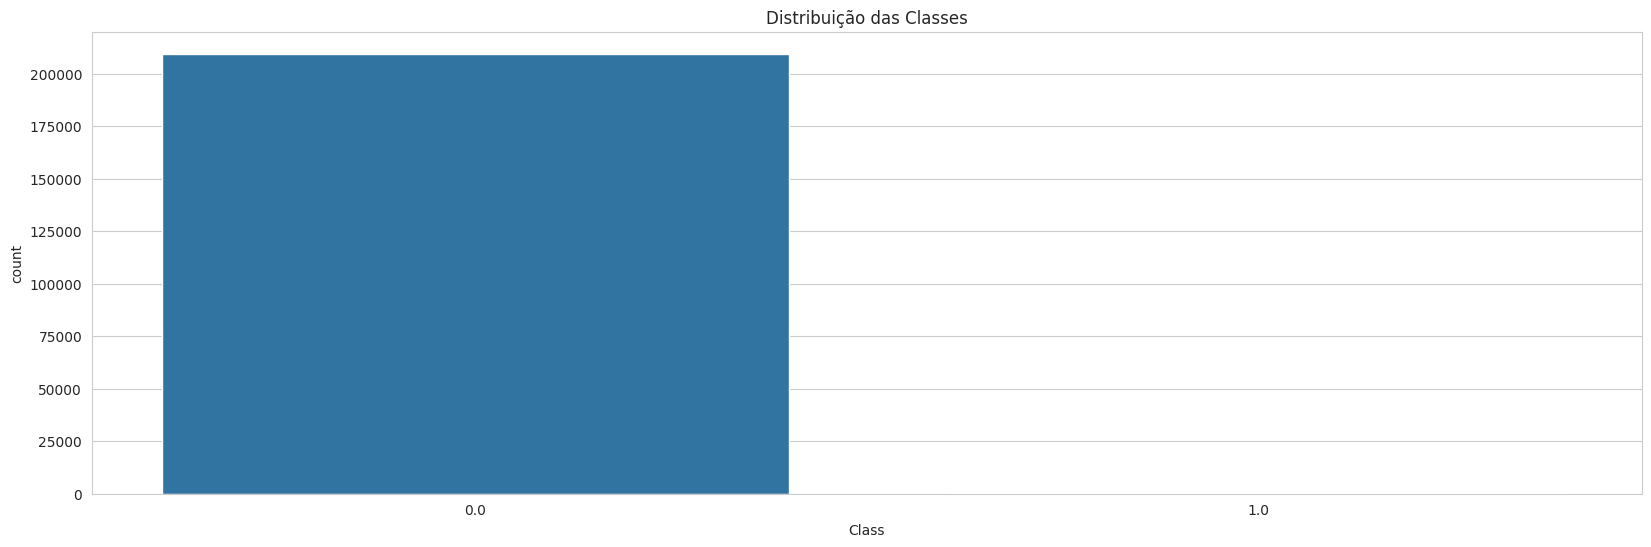

In [19]:
# ver o balanceamento das classes
print(dados.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((dados[dados.Class == 1].shape[0] / dados.shape[0]) * 100))

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots(figsize = (20,6))
sns.countplot(x='Class', data=dados, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

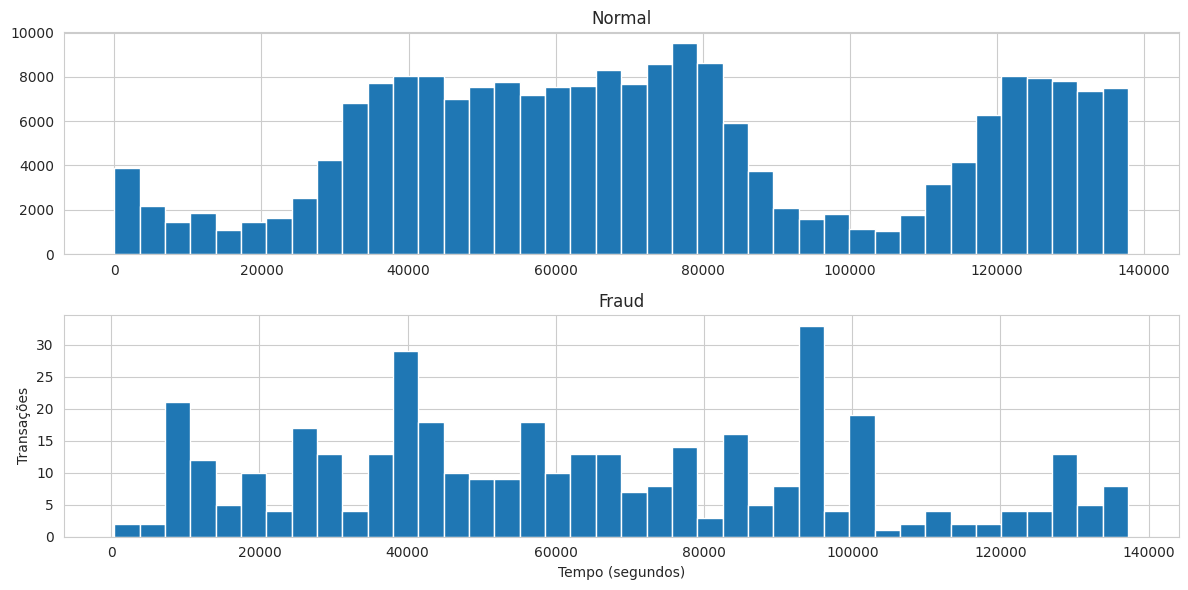

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(dados.Time[dados.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(dados.Time[dados.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Seguindo a análise exploratória, plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.

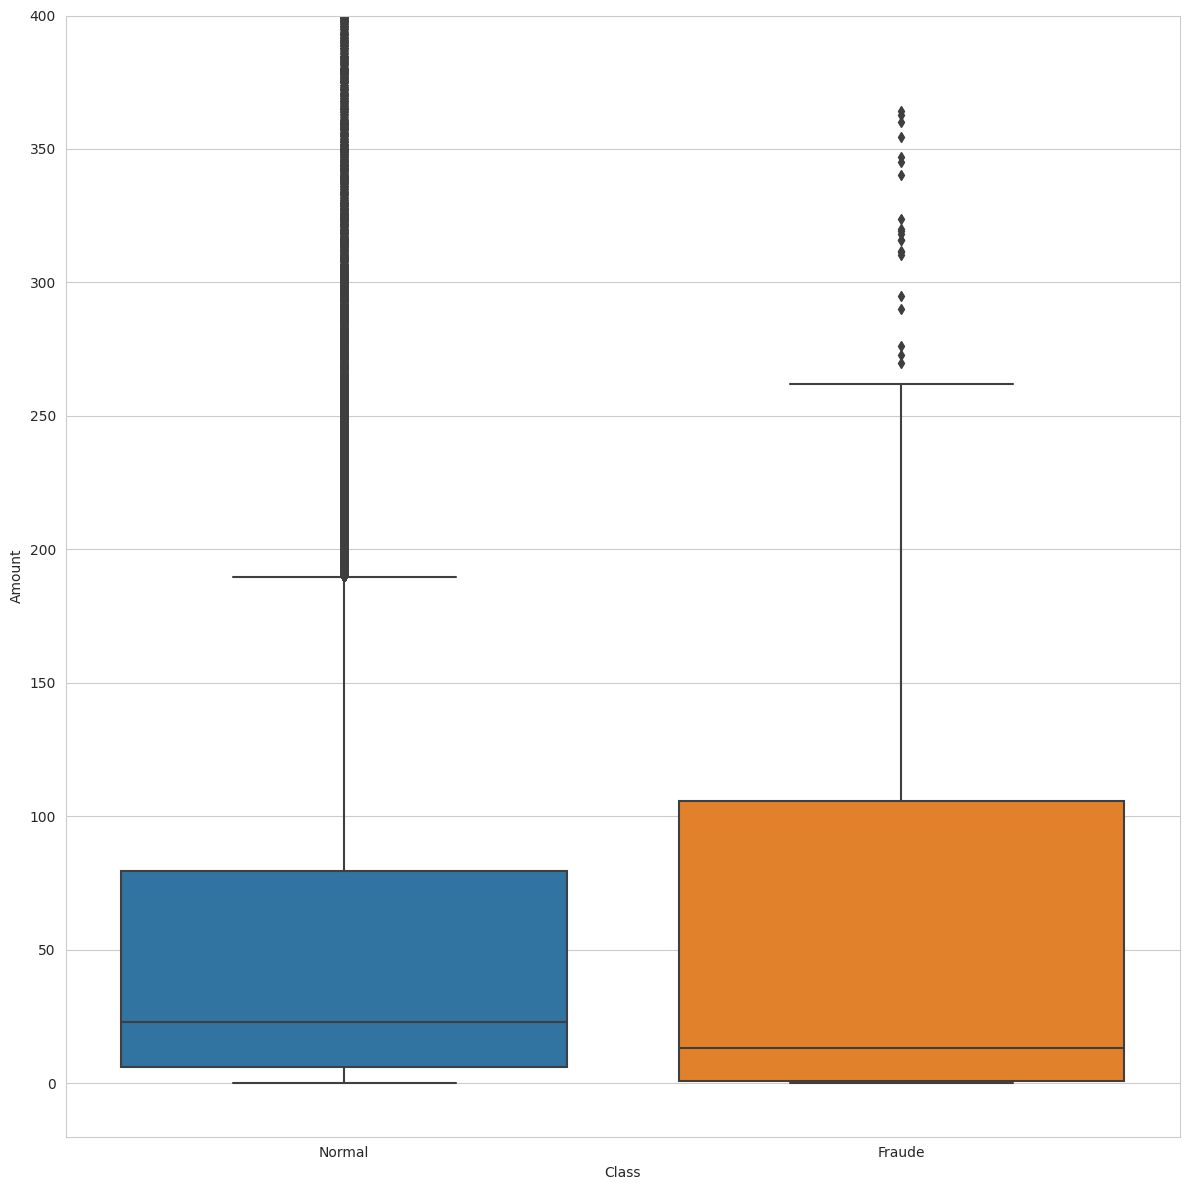

In [23]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x=dados.Class, y=dados.Amount)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

As informações estatísticas para `df.Class == 1` mostram que a sua média exata está em 118.13 e a mediana em 9.21.

In [24]:
dados.query('Class == 1 & Amount < 2000')['Amount'].describe()

count     393.000000
mean      118.077048
std       236.385961
min         0.000000
25%         1.000000
50%        12.310000
75%       105.890000
max      1809.680000
Name: Amount, dtype: float64

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis `V3`, `V4`, `V10` e `V11`, como elas são bem distintas.

Por outro lado, variáveis como `V8`, `V13` e `V15` são muito similares, apresentando aproximadamente o mesmo comportamento.

<ipython-input-25-8315afbe59b3>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
<ipython-input-25-8315afbe59b3>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
<ipython-input-25-8315afbe59b3>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
<ipython-input-25-8315afbe59b3>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_class_1[col], label="Class 1", shad

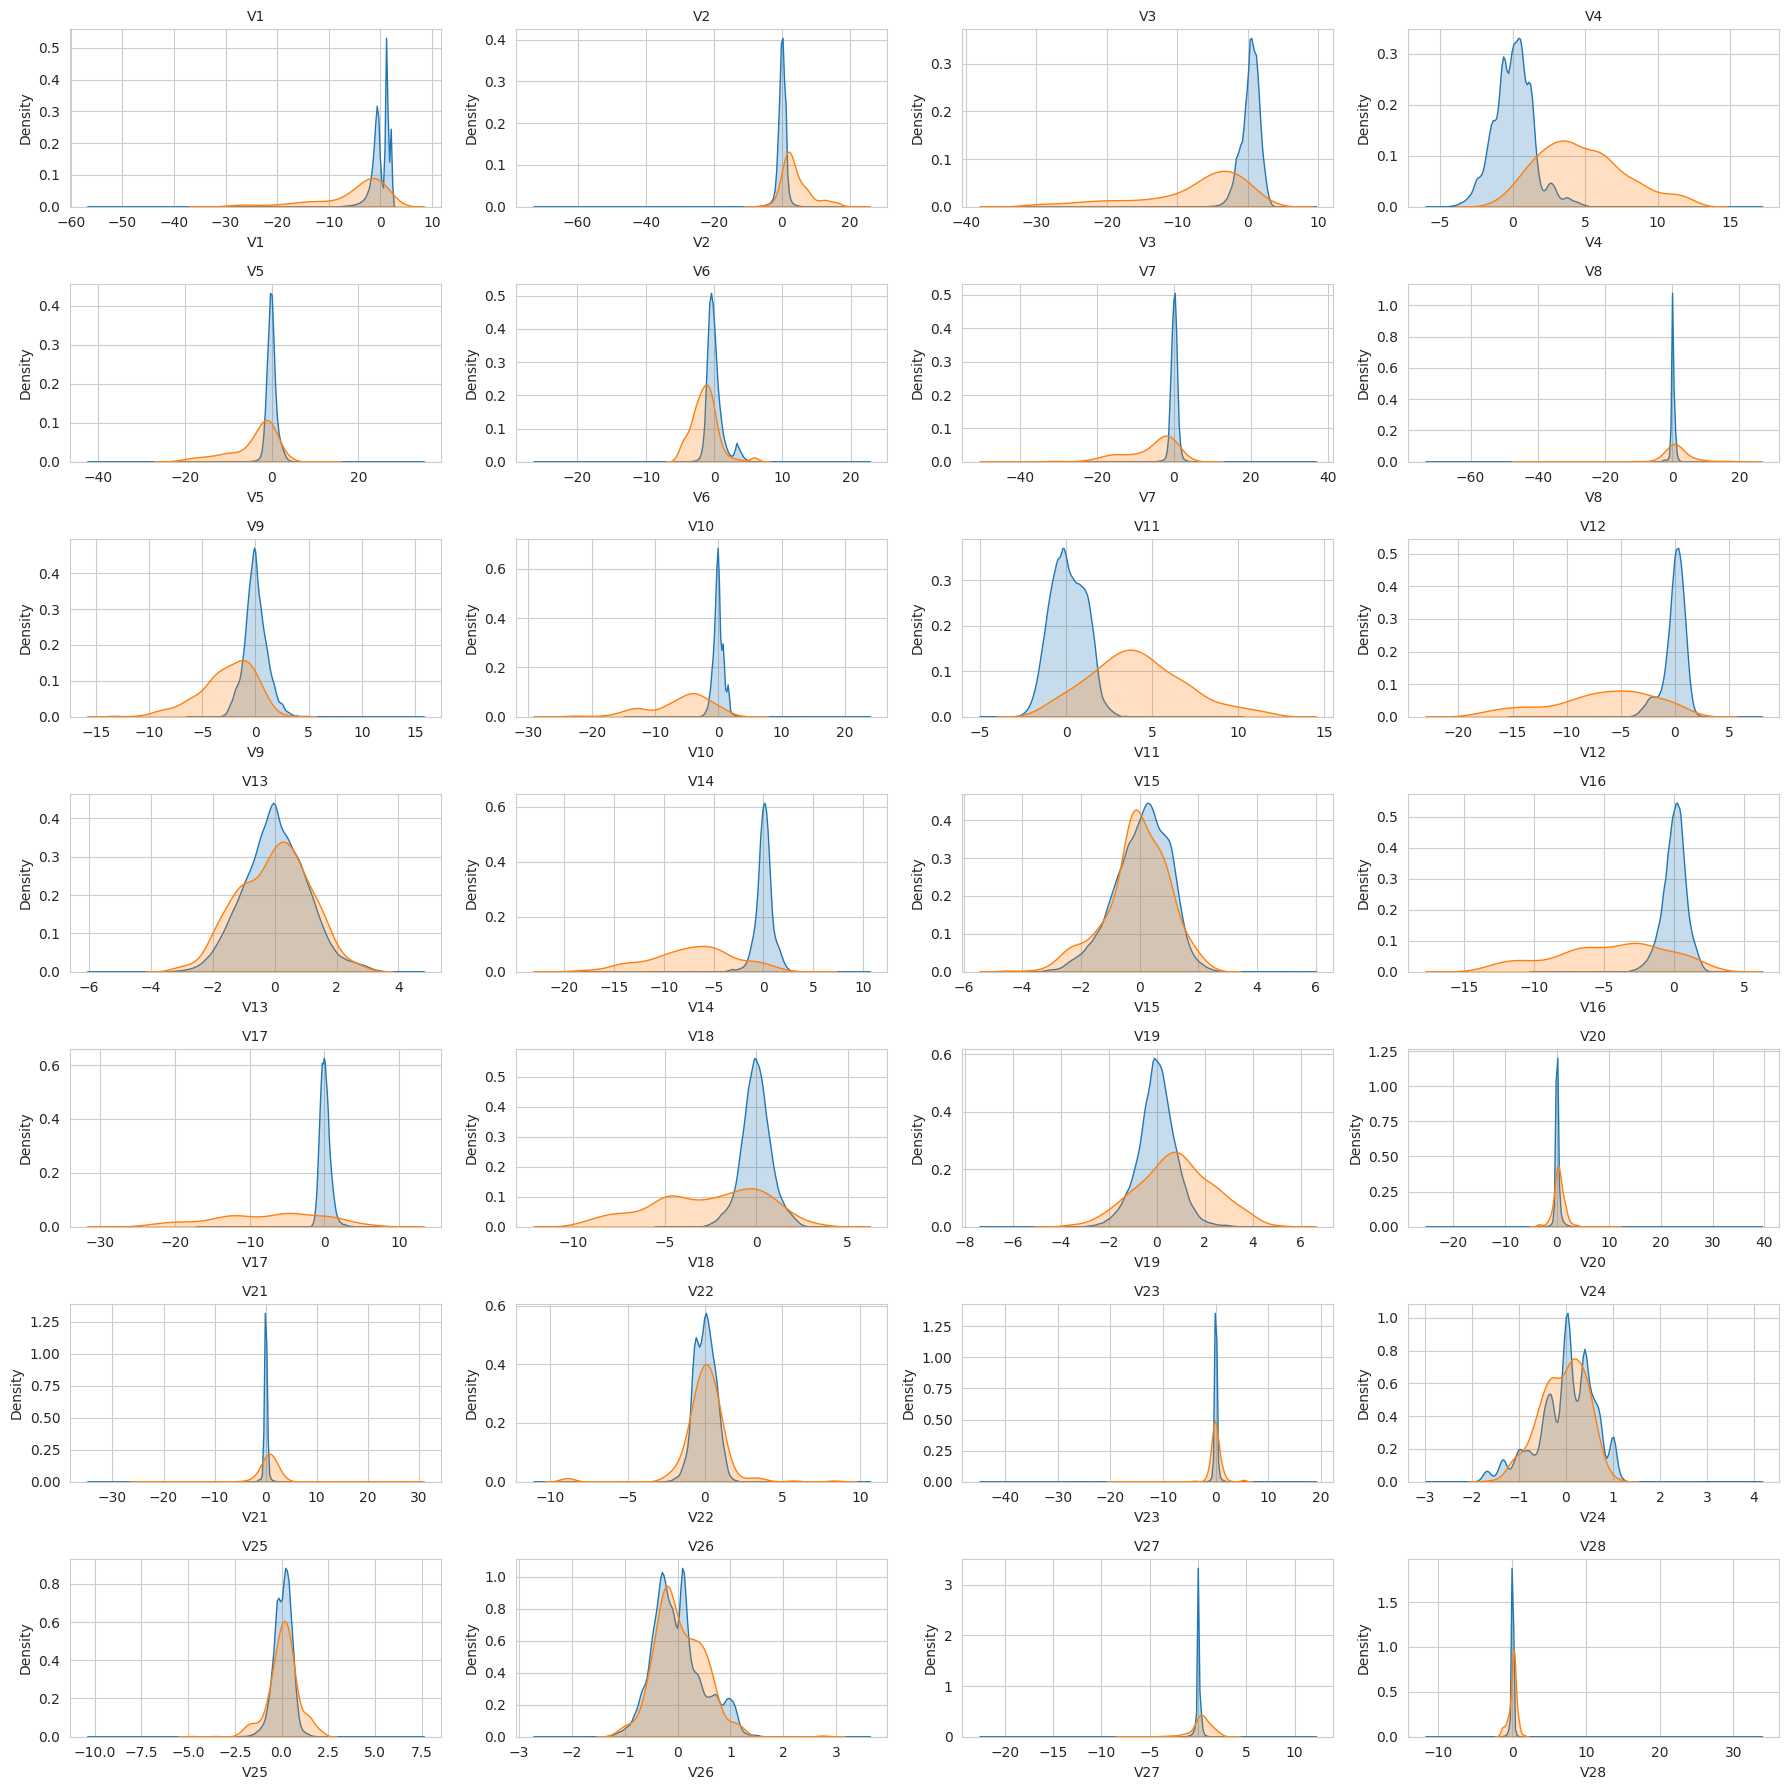

In [25]:
column_names = dados.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = dados.query('Class == 0')
df_class_1 = dados.query('Class == 1')

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)

plt.tight_layout()

Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.